## Method definitions

In [1]:
def clean_df(df, cols_to_drop):
    """
    Drops columns and does performs basic encodings

    INPUT:
    df: DataFrame to clean
    cols_to_drop: list of columns which will be droped
    
    OUTPUT:
    cleaned_df: Cleaned DataFrame
    """
    
    df.drop(columns=cols_to_drop, inplace=True)
    # EINGEFUEGT_AM to datetime
    df.EINGEFUEGT_AM = pd.to_datetime(df.EINGEFUEGT_AM, format='%Y-%m-%d ').dt.year
    
    # OST_WEST_KZ O, W to 0, 1
    df.OST_WEST_KZ.replace('O', 0, inplace=True)
    df.OST_WEST_KZ.replace('W', 1, inplace=True)
    
    # drop rows with more than 0.08 % (29) of missing values
    df.dropna(axis=0, inplace=True, thresh=df.shape[1] - 29)
    
    return df

In [2]:
def encode_to_nan(df, encodings):
    """
    Takes a DataFrame and replaces the keys which are given by encoding the default nan value with real nan
    
    INPUT:
    df: DataFrame to encode
    encodings: DataFrame with encodings
    
    OUTPUT:
    encoded_df: Encoded DataFrame
    """

    for idx, row in encodings.iterrows():
        placeholder = row.Value
        encoding = row.Attribute
        
        try:
            col_type = df[encoding].dtype
        except KeyError:
            continue # col not in DF
        
        if col_type == np.int64 or col_type == np.float64:
            try:
                placeholder = int(placeholder)
            except:
                continue
        
        df[encoding].replace(placeholder, np.nan, inplace=True)
        
    return df

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# magic word for producing visualizations in notebook
%matplotlib inline

matplotlib.rc('figure', figsize=(16, 8))

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
customers = pd.read_csv('./arvato-data/Udacity_CUSTOMERS_052018.csv', sep=';')

/home/moritz/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
azdias = pd.read_csv('./arvato-data/Udacity_AZDIAS_052018.csv', sep=';')

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
# lets take a look at the general population
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [9]:
customers.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [10]:
azdias.OST_WEST_KZ.unique()

array([nan, 'W', 'O'], dtype=object)

In [11]:
customers.PRODUCT_GROUP.unique() # only exists for customers

array(['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'], dtype=object)

In [12]:
customers.CUSTOMER_GROUP.unique() # binary

array(['MULTI_BUYER', 'SINGLE_BUYER'], dtype=object)

We also can encode binary OST_WEST for both DFs, we will write a clean_df method which does that. See under Metho definitions at top of the Notebook. 

Furthermore, the Date column needs to be parsed.

We are very high dimensional having 369 (366 on the general data) dimensions, it seems that we also have lots of NaN values, we will further check this.

According to the Excel files we have more values which could be NaN to but are currently encoded as a string, but lets see how they are currently encoded e.g. AGER_TYP -1 means missing

In [13]:
azdias.AGER_TYP

0        -1
1        -1
2        -1
3         2
4        -1
         ..
891216   -1
891217   -1
891218   -1
891219   -1
891220   -1
Name: AGER_TYP, Length: 891221, dtype: int64

We should encode -1 etc from Excel to nan, as it indicates a missing value, so we can get real insights about the missing data per column.

In [14]:
encodings = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1)

In [15]:
encodings.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [16]:
idx_mask = encodings.Meaning.str.contains('unknown').replace(np.nan, False)

nan_encodings = encodings[idx_mask]

In [17]:
# thats 233 encodings for nan, we should now replace them
encode_to_nan(azdias, nan_encodings)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,NaN,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,NaN,9.0,NaN,17.0,NaN,NaN,NaN,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


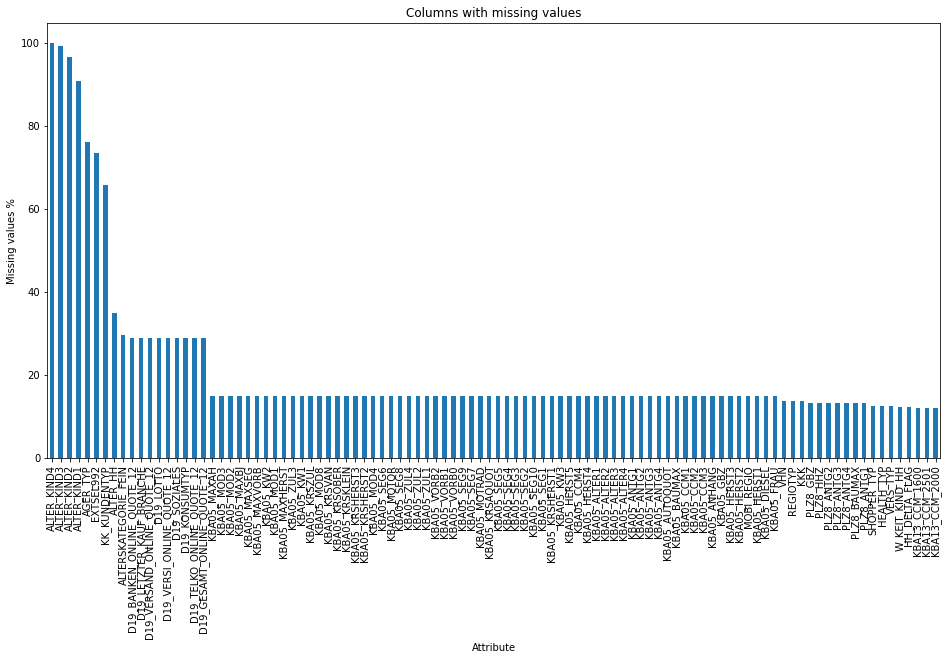

In [18]:
fig = (azdias.isna().sum(axis=0) / azdias.shape[0] * 100).sort_values(ascending=False).iloc[0:100].plot(kind='bar', figsize=(16,8), title='Columns with missing values');

fig.set_xlabel('Attribute')
fig.set_ylabel('Missing values %')
fig.figure.savefig('100_missing_values.png', dpi=500);

We can see, that we have many NaN values columns, we should drop columns with too many missing values.
We draw the line at 25 %.

In [19]:
# lets find columns with more than 30 % NaN values
na_srs = ((azdias.isna().sum(axis=0) / azdias.shape[0]) >= 0.25)
na_cols = na_srs[na_srs == True].index.tolist()

# free mem
del na_srs

na_cols

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [20]:
cols_to_drop = na_cols.append('LNR') # LNR is just an id

In [21]:
# Also check rows with many missing values
na_rows = azdias.isna().sum(axis=1)

In [22]:
num_cols = azdias.shape[1]
most_missing_rows = (na_rows / num_cols * 100).sort_values(ascending=False)
most_missing_rows

537799    71.311475
826869    71.311475
373501    71.311475
55664     71.311475
350182    71.311475
            ...    
454279     0.000000
403940     0.000000
292424     0.000000
554151     0.000000
410019     0.000000
Length: 891221, dtype: float64

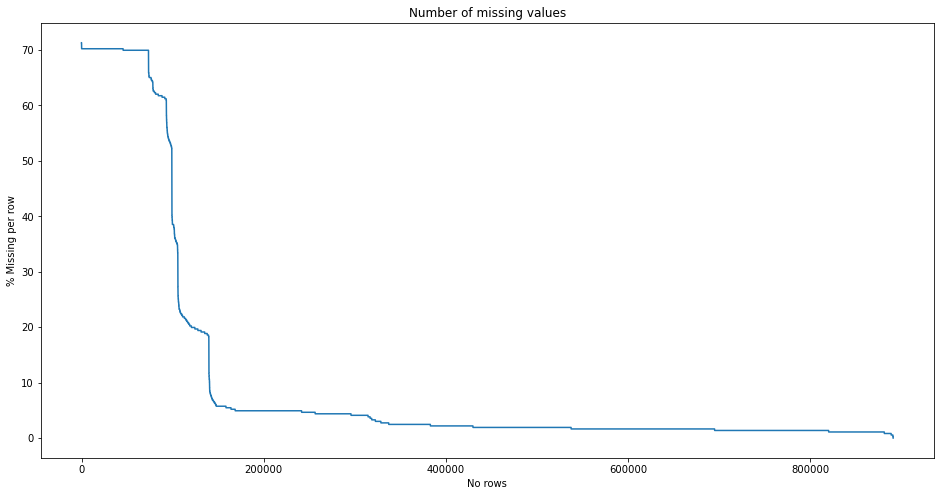

In [23]:
plt.plot(most_missing_rows.values);
plt.title('Number of missing values')
plt.ylabel('% Missing per row')
plt.xlabel('No rows')
plt.savefig('missing_val_per_row.png', dpi=500)

__We can see, that we have rows with many missing values, we should find a good threshold to drop columns with too many nans. Especially around around 8 % it flattens a lot, lets check how many rows we will really loose if we drop rows with more than 8 % missing columns. According to the plot it should be around 150,000 of our 890,000 rows.__

In [24]:
loosing_cols = most_missing_rows[most_missing_rows > 8].shape[0]
loosing_cols

141277

In [25]:
# We will loose 142,380 cols
# 8 % of nans is
total_nan = 0.08 * azdias.shape[1]

print(f'Percentual loosing {round(loosing_cols / azdias.shape[0] * 100, 2)} % rows but this way we are getting rid of any row with more than 8 % ({round(total_nan)} entries) of nans!')


Percentual loosing 15.85 % rows but this way we are getting rid of any row with more than 8 % (29 entries) of nans!


__We put this threshold of 29 entries into our clean_df method__

In [26]:
clean_df(azdias, na_cols)

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,8C,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,5.0,15.0,0.0,0.0,1.0,11.0,0.0,NaN,6.0,7A,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,9.0,11.0,0.0,0.0,1.0,11.0,0.0,4.0,7.0,9D,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,1.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,5.0,4C,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,9.0,7.0,0.0,1.0,1.0,5.0,0.0,4.0,2.0,9D,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [27]:
# TODO: after dropping the columns, lets check for some high correlation between features

## Next: Imputation and Scaling

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [28]:
mailout_train = pd.read_csv('./arvato-data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/moritz/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
